In [1]:
import pandas as pd
import nflfastpy as nfl
import time
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

C:\Users\dymar\anaconda3\lib\site-packages\nflfastpy\__init__.py:16: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  default_headshot = mpl_image.imread(headshot_url)


In [2]:
#Creating and then doing a concatinate for the years 2015-2020.
df = pd.DataFrame()
for year in range(2015, 2020):
    yearly_df = nfl.load_pbp_data(year)
    df = pd.concat([df, yearly_df])

In [3]:
#Making sure to filter by rushing touchdowns and not two point attempts
rushing_df_filters = (df['rush_attempt'] == 1) & (df['two_point_attempt'] == 0)

#Pulling in relevant columns
rushing_df = df.loc[rushing_df_filters, ['rush_attempt', 'rush_touchdown', 'yardline_100']]

#Counting how many rushing touchdowns at the yard line. Normalize function allows us to get a number back.
rushing_df_probs = rushing_df.groupby('yardline_100')['rush_touchdown'].value_counts(normalize=True)

#Since this is a list object we convert it to a data frame and set the index using the prior data frame
rushing_df_probs = pd.DataFrame({'probability_of_touchdown': rushing_df_probs.values}, index=rushing_df_probs.index).reset_index()

#We only care if rushing touchdown is equal to 1 since zero means a touchdown did not happen
rushing_df_probs = rushing_df_probs.loc[rushing_df_probs['rush_touchdown'] == 1, ['yardline_100', 'probability_of_touchdown']]
rushing_df_probs.head()

,yardline_100,probability_of_touchdown
0,1.0,0.560390
3,2.0,0.428058
5,3.0,0.336910
7,4.0,0.304251
9,5.0,0.206349


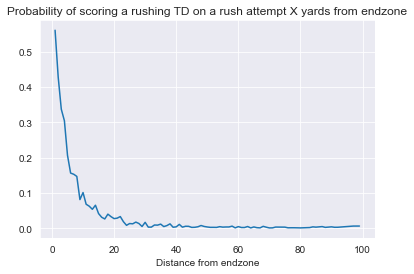

In [4]:
#Graphing to double check results. The closer to the end zone, the greater probability of a touchdown
plt.plot(rushing_df_probs['yardline_100'], rushing_df_probs['probability_of_touchdown']);
plt.title('Probability of scoring a rushing TD on a rush attempt X yards from endzone');
plt.xlabel('Distance from endzone');

In [5]:
#Importing 2020 Data
df_2020 = nfl.load_pbp_data(2020)

In [6]:
#Bringing in RB data
roster_2020 = nfl.load_roster_data(2020)
rbs = roster_2020.loc[roster_2020['position'] == 'RB']['gsis_id']
rbs.head()

60    00-0033118
61    00-0034681
62    00-0033797
63    00-0036383
64    00-0032577
Name: gsis_id, dtype: object

In [7]:
#Locating rushing attempts equal to 1 and then bringing in respective columns
rushing_df_2020 = df_2020.loc[df_2020['rush_attempt'] == 1, ['rusher_id', 'rusher_player_name', 'rush_attempt','rush_touchdown', 'yardline_100']]

#Locating rushing id for RBs
rushing_df_2020 = rushing_df_2020.loc[rushing_df_2020['rusher_id'].isin(rbs)]

#Merging the two data frames
rushing_df_2020 = rushing_df_2020.merge(rushing_df_probs, how='left', on='yardline_100')

#Using the agg fuction to perform different operations on different columns. Sum/first/etc.
rushing_df_2020 = rushing_df_2020.groupby('rusher_id', as_index=False).agg({'rusher_player_name': 'first', 'rush_touchdown': 'sum', 'probability_of_touchdown': 'sum'}).rename({'probability_of_touchdown': 'expected_touchdowns', 'rush_touchdown': 'actual_touchdowns'}, axis=1)

rushing_df_2020['positive_regression_candidate'] = rushing_df_2020['actual_touchdowns'] < rushing_df_2020['expected_touchdowns']

rushing_df_2020['delta'] = rushing_df_2020.apply(lambda x: abs(x.expected_touchdowns - x.actual_touchdowns), axis=1)

rushing_df_2020.sort_values(by='expected_touchdowns', ascending=False).head()

,rusher_id,rusher_player_name,actual_touchdowns,expected_touchdowns,positive_regression_candidate,delta
57,00-0033893,D.Cook,16.0,15.776227,False,0.223773
36,00-0032764,D.Henry,17.0,14.290648,False,2.709352
43,00-0033118,K.Drake,10.0,13.998086,True,3.998086
42,00-0033045,E.Elliott,6.0,13.545488,True,7.545488
115,00-0035700,J.Jacobs,12.0,12.721041,True,0.721041


C:\Users\dymar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


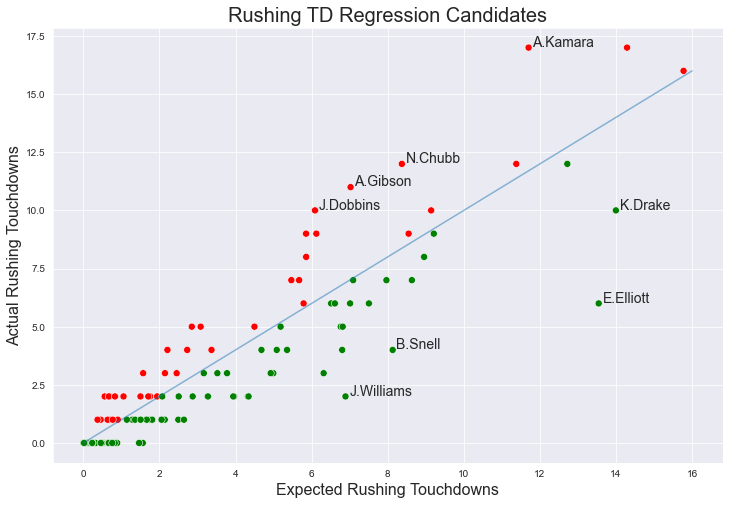

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(
    x = 'expected_touchdowns',
    y = 'actual_touchdowns',
    hue = 'positive_regression_candidate',
    data = rushing_df_2020,
    palette = ['r', 'g'], # red and green,
    s=50
);

max_act_touchdowns = int(rushing_df_2020['actual_touchdowns'].max()) # max touchdowns
max_exp_touchdowns = int(rushing_df_2020['expected_touchdowns'].max()) # max expected touchdowns

max_tds = max(max_act_touchdowns, max_exp_touchdowns) # max of actual and expected tds

sns.lineplot(range(max_tds), range(max_tds), alpha=0.5); # plotting a line with slope of 1 up to max_tds number. This is the blue line on our viz

#15 players with the highest delta between expected and actual TDs (negative or positive)
top_x_delta = rushing_df_2020.sort_values(by='delta', ascending=False)[:8]

#Iteratting over the dataframe
for _, row in top_x_delta.iterrows(): 
    ax.text(
        x = row['expected_touchdowns']+.1, # add a bit of spacing from the point in the x-direction
        y = row['actual_touchdowns'] + 0.05, # same but in the y-direction
        s = row['rusher_player_name'], # annotate with the player's name,
        fontsize=14
    )
ax.get_legend().remove()
ax.set_title('Rushing TD Regression Candidates', fontsize=20)
ax.set_xlabel('Expected Rushing Touchdowns', fontsize=16)
ax.set_ylabel('Actual Rushing Touchdowns', fontsize=16);